# Algoritmos Evolutivos & Aprendizado por Reforço

## Alunos

- João Vitor Vendemiato Fatoretto - 199944
- Natan Beltrão da Cunha Pevidor Carvalho - 184972

## Divisão de Tarefas:

- João Vitor - Aprendizado por Reforço
- Natan - Algoritmos Evolutivos

## Parte 1 - Algoritmos Evolutivos

Neste projeto, treinamos dois algoritmos diferentes para aprender a jogar o jogo Pacman ([código](https://gitlab.techniek.hva.nl/artificial-intelligence/pacman-contest-3)). Nesta primeira parte, treinamos um algoritmo evolutivo.

Como os fantasmas do jogo se comportam de forma aleatória, não é possível encontrar um caminho fixo para a vitória. Por isso, tentamos desenvolver um algoritmo que chegasse a uma estratégia ideal e não um caminho fixo. Para isso, nos inspiramos em Brandstetter & Ahmadi, 2012.

Uma estratégia (implementada em [strategy.py](./strategy.py)) consiste em uma matriz n x 4 de árvores. Cada coluna é responsável por uma das 4 direções possíveis e cada linha "vota" em uma direção. A direção com o maior número de "votos" será a escolhida desde que não seja a direção oposta à direção atual. Tivemos que impedir a direção oposta pois as estratégias muitas vezes entravam em um "loop".

O sistema de votação se baseia no cálculo de valores a partir de árvores, onde as folhas consistem em valores calculados a partir do estado do jogo (como posição e distância de elementos) e os outros nós são operações entre dois valores.

### Valores

Os valores (implementados em [values.py](./values.py)) possíveis para as folhas de uma árvore são:

- Coordenadas do Pacman
- Quantidade, distância e coordenadas do fantasma não-comestível mais próximo
- Quantidade, distância e coordenadas do fantasma comestível mais próximo
- Quantidade, distância e coordenadas da comida mais próxima
- Quantidade, distância e coordenadas da cápsula mais próxima
- A última direção percorida, onde o valor é 1 se a direção consultada foi a última ou 0 se não.
- Valores constantes: -1, 0, 0.1, 0.5, 1, 2, 10

### Operadores

Os operadores (implementados em [operators.py](./operators.py)) possíveis para os outros nós são:

- Subtração
- Adição
- Multiplicação
- Divisão (retorna 0 caso o divisor seja 0)
- Máximo
- Mínimo
- Média aritmética

### Geração Inicial

Para criar a primeira geração, implementamos em [strategyGenerator.py](./strategyGenerator.py) um mecanismo de geração de árvpres, onde a chance de um nó ser uma folha aumenta conforme sua profundidade, de forma a gerar árvores com tamanhos variados mas que tendam a não serem muito grandes. Inicialmente, todas as estratégias possuem 1000 linhas de 4 árvores. Cada geração possui 50 estratégias.

In [1]:
import strategyGenerator

def createGeneration(size=50):
    generation = []
    for _ in range(size):
        generation.append(strategyGenerator.generateStrategy())
    return generation

Para cada estratégia em uma geração, executamos 1 jogo. A medida de fitness de cada estratégia é a pontuação obtida menos 10 vezes a quantidade de comida restante e 40 vezes a quantidade de cápsulas restantes. Adotamos essa função pois, utilizando apenas a pontuação, o Pacman tendia a adotar estratégias "suicidas", onde buscava ir em direção aos fantasmas para evitar a perde de pontuação gerada pelo tempo de uma partida.

Ao final de cada execução, utilizamos o método da roleta para selecionar os membros que irão para a próxima geração, dos quais:

- 10% serão estratégias sobreviventes, simplesmente replicadas da geração anterior
- 10% serão estratégias com alguma mutação
- 80% serão estratégias resultantes da reprodução de duas estratégias da geração anterior, com crossover

Para o método da roleta, utilizamos a raiz quadrada da função fitness (com windowing para evitar raízes negativas).

### Mutação

As mutações possíveis, implementadas em [generationReproduction.py](./generationReproduction.py), são:

- Adição de mais 50 linhas de 4 árvores
- Remoção de 50 linhas arbitrárias da estratégia

### Crossover

O crossover, também implementado em [generationReproduction.py](./generationReproduction.py), seleciona metade das linhas de cada estratégia e gera uma estratégia nova com elas.

Executamos, então, 30 gerações para cada layout do jogo, iniciando com smallClassic. A cada geração, guardamos a estratégia com o maior valor de fitness.

Ao final, rodamos 10 partidas com cada uma das estratégias guardadas e retornamos a estratégia que obteve a melhor pontuação. Optamos por isso, pois o movimento dos fantasmas é aleatório e o desempenho em um jogo apenas não é capaz de representar de forma adequada o desempenho de uma estratégia. Porém, rodar várias partidas para todas as estratégias de cada geração seria muito custoso.

In [2]:
import generationReproduction
import globalValues
import numpy as np
import pacman
import time
import copy

def selectByRoulette(gen, scores):
    probability = np.sqrt(np.array(scores) - min(scores))
    probability = probability / np.sum(probability)
    return np.random.choice(gen, p=probability)

def runGeneticLearning(layout, generation, iterations=30, numGames=1):
    startTime = time.time()
    generationAverage = []
    generationMax = []
    generationMin = []
    winningStrategies = []
    
    args = pacman.readCommand(["-l", layout, "-p", "GeneticAgent", "-n", str(numGames), "-q"])
    for i in range(iterations):
        print("\n\n\n======== STARTING GENERATION %s ========\n\n\n" % i)
        averageScore = []
        fitness = []

        for strategy in generation:
            globalValues.strategy = strategy
            games = pacman.runGames(**args)
            scores = [g.state.getScore() for g in games]
            individualFitness = [g.state.getScore() - 10 * g.state.getNumFood() - 40 * len(g.state.getCapsules()) for g in games]
            averageScore.append(sum(scores)/len(scores))
            fitness.append(sum(individualFitness))

        generationAverage.append(sum(averageScore)/len(averageScore))
        generationMax.append(max(averageScore))
        generationMin.append(min(averageScore))
        winningStrategies.append(copy.deepcopy(generation[fitness.index(max(fitness))]))

        if i < iterations - 1:
            newGeneration = []
            for _ in range(round(len(generation) / 10)):
                newGeneration.append(selectByRoulette(generation, fitness))
            for _ in range(round(len(generation) / 10)):
                newGeneration.append(generationReproduction.mutate(selectByRoulette(generation, fitness)))
            for _ in range(round(len(generation) - len(newGeneration))):
                firstStrategy = selectByRoulette(generation, fitness)
                secondStrategy = selectByRoulette(generation, fitness)
                newGeneration.append(generationReproduction.crossover(firstStrategy, secondStrategy))
            generation = newGeneration
    
    winningStrategiesAverageScores = []
    args = pacman.readCommand(["-l", layout, "-p", "GeneticAgent", "-n", "10", "-q"])
    for strategy in winningStrategies:
        globalValues.strategy = strategy
        games = pacman.runGames(**args)
        scores = [g.state.getScore() for g in games]
        winningStrategiesAverageScores.append(sum(scores)/len(scores))
    winningStrategy = winningStrategies[winningStrategiesAverageScores.index(max(winningStrategiesAverageScores))]
    print("Winning Strategy:", winningStrategy)
    print("Winning Strategy's Generation:", winningStrategiesAverageScores.index(max(winningStrategiesAverageScores)))
    print("Winning Strategy's Average Score:", max(winningStrategiesAverageScores))
    print("Execution time: %s minutes" % ((time.time() - startTime) / 60))
    return (generationAverage, generationMax, generationMin, winningStrategy)

In [3]:
generation = createGeneration()
generationAverage, generationMax, generationMin, smallClassicStrategy = runGeneticLearning("smallClassic", generation)

layout:  smallClassic



======== STARTING GENERATION 0 ========



Pacman died! Score: -356
Average Score: -356.0
Scores:        -356.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -347
Average Score: -347.0
Scores:        -347.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -348
Average Score: -348.0
Scores:        -348.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 214
Average Score: 214.0
Scores:        214.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -392
Average Score: -392.0
Scores:        -392.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -302
Average Score: -302.0
Scores:        -302.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -392
Average Score: -392.0
Scores:        -392.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -311
Average Score: -311.0
Scores:        -311.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Sc

Pacman died! Score: -338
Average Score: -338.0
Scores:        -338.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 7
Average Score: 7.0
Scores:        7.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -5
Average Score: -5.0
Scores:        -5.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -358
Average Score: -358.0
Scores:        -358.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -104
Average Score: -104.0
Scores:        -104.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -367
Average Score: -367.0
Scores:        -367.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 19
Average Score: 19.0
Scores:        19.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -184
Average Score: -184.0
Scores:        -184.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -149
Average Score: -149.0
Scores:        -149.0
Win Rate:      0/1 (0.00)
Record

Pacman died! Score: -365
Average Score: -365.0
Scores:        -365.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -35
Average Score: -35.0
Scores:        -35.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -446
Average Score: -446.0
Scores:        -446.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -157
Average Score: -157.0
Scores:        -157.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -195
Average Score: -195.0
Scores:        -195.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 67
Average Score: 67.0
Scores:        67.0
Win Rate:      0/1 (0.00)
Record:        Loss



======== STARTING GENERATION 3 ========



Pacman died! Score: -356
Average Score: -356.0
Scores:        -356.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -374
Average Score: -374.0
Scores:        -374.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -383
Average Score: -38

Pacman died! Score: -132
Average Score: -132.0
Scores:        -132.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -172
Average Score: -172.0
Scores:        -172.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -131
Average Score: -131.0
Scores:        -131.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -383
Average Score: -383.0
Scores:        -383.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 45
Average Score: 45.0
Scores:        45.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -433
Average Score: -433.0
Scores:        -433.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -347
Average Score: -347.0
Scores:        -347.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -365
Average Score: -365.0
Scores:        -365.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -168
Average Score: -168.0
Scores:        -168.0
Win Rate:      0/

Pacman died! Score: -299
Average Score: -299.0
Scores:        -299.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -243
Average Score: -243.0
Scores:        -243.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -270
Average Score: -270.0
Scores:        -270.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -218
Average Score: -218.0
Scores:        -218.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -322
Average Score: -322.0
Scores:        -322.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -333
Average Score: -333.0
Scores:        -333.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -383
Average Score: -383.0
Scores:        -383.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -324
Average Score: -324.0
Scores:        -324.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 206
Average Score: 206.0
Scores:        206.0
Win Rate:     

Pacman died! Score: -331
Average Score: -331.0
Scores:        -331.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 424
Average Score: 424.0
Scores:        424.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 45
Average Score: 45.0
Scores:        45.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -347
Average Score: -347.0
Scores:        -347.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -86
Average Score: -86.0
Scores:        -86.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -347
Average Score: -347.0
Scores:        -347.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -365
Average Score: -365.0
Scores:        -365.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -125
Average Score: -125.0
Scores:        -125.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 26
Average Score: 26.0
Scores:        26.0
Win Rate:      0/1 (0.00)
Rec

Pacman died! Score: 68
Average Score: 68.0
Scores:        68.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -242
Average Score: -242.0
Scores:        -242.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -148
Average Score: -148.0
Scores:        -148.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -383
Average Score: -383.0
Scores:        -383.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -421
Average Score: -421.0
Scores:        -421.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -306
Average Score: -306.0
Scores:        -306.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -261
Average Score: -261.0
Scores:        -261.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -218
Average Score: -218.0
Scores:        -218.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -113
Average Score: -113.0
Scores:        -113.0
Win Rate:      0/

Pacman died! Score: 8
Average Score: 8.0
Scores:        8.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -204
Average Score: -204.0
Scores:        -204.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -120
Average Score: -120.0
Scores:        -120.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -356
Average Score: -356.0
Scores:        -356.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -356
Average Score: -356.0
Scores:        -356.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 219
Average Score: 219.0
Scores:        219.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -179
Average Score: -179.0
Scores:        -179.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -302
Average Score: -302.0
Scores:        -302.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -342
Average Score: -342.0
Scores:        -342.0
Win Rate:      0/1 (0.0

Pacman died! Score: -374
Average Score: -374.0
Scores:        -374.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 248
Average Score: 248.0
Scores:        248.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -322
Average Score: -322.0
Scores:        -322.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -226
Average Score: -226.0
Scores:        -226.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -356
Average Score: -356.0
Scores:        -356.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -358
Average Score: -358.0
Scores:        -358.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -312
Average Score: -312.0
Scores:        -312.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -347
Average Score: -347.0
Scores:        -347.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 301
Average Score: 301.0
Scores:        301.0
Win Rate:      0/

Pacman died! Score: 108
Average Score: 108.0
Scores:        108.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 34
Average Score: 34.0
Scores:        34.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 194
Average Score: 194.0
Scores:        194.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 47
Average Score: 47.0
Scores:        47.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -214
Average Score: -214.0
Scores:        -214.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -157
Average Score: -157.0
Scores:        -157.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -105
Average Score: -105.0
Scores:        -105.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -173
Average Score: -173.0
Scores:        -173.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -383
Average Score: -383.0
Scores:        -383.0
Win Rate:      0/1 (0.00)
Rec

Pacman died! Score: -311
Average Score: -311.0
Scores:        -311.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -125
Average Score: -125.0
Scores:        -125.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 213
Average Score: 213.0
Scores:        213.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -219
Average Score: -219.0
Scores:        -219.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -338
Average Score: -338.0
Scores:        -338.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -356
Average Score: -356.0
Scores:        -356.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -335
Average Score: -335.0
Scores:        -335.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -115
Average Score: -115.0
Scores:        -115.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 247
Average Score: 247.0
Scores:        247.0
Win Rate:      0/

Pacman died! Score: -248
Average Score: -248.0
Scores:        -248.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -356
Average Score: -356.0
Scores:        -356.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -296
Average Score: -296.0
Scores:        -296.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 277
Average Score: 277.0
Scores:        277.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -383
Average Score: -383.0
Scores:        -383.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 158
Average Score: 158.0
Scores:        158.0
Win Rate:      0/1 (0.00)
Record:        Loss



======== STARTING GENERATION 16 ========



Pacman died! Score: -311
Average Score: -311.0
Scores:        -311.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 62
Average Score: 62.0
Scores:        62.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 2
Average Score: 2.0
Scor

Pacman died! Score: -321
Average Score: -321.0
Scores:        -321.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -374
Average Score: -374.0
Scores:        -374.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 120
Average Score: 120.0
Scores:        120.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -356
Average Score: -356.0
Scores:        -356.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -64
Average Score: -64.0
Scores:        -64.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 225
Average Score: 225.0
Scores:        225.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -282
Average Score: -282.0
Scores:        -282.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -129
Average Score: -129.0
Scores:        -129.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -239
Average Score: -239.0
Scores:        -239.0
Win Rate:      0/1 (

Pacman died! Score: -357
Average Score: -357.0
Scores:        -357.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 93
Average Score: 93.0
Scores:        93.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -374
Average Score: -374.0
Scores:        -374.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -17
Average Score: -17.0
Scores:        -17.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -308
Average Score: -308.0
Scores:        -308.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -330
Average Score: -330.0
Scores:        -330.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -147
Average Score: -147.0
Scores:        -147.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -247
Average Score: -247.0
Scores:        -247.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 526
Average Score: 526.0
Scores:        526.0
Win Rate:      0/1 (0.0

Pacman died! Score: -293
Average Score: -293.0
Scores:        -293.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 49
Average Score: 49.0
Scores:        49.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -306
Average Score: -306.0
Scores:        -306.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 230
Average Score: 230.0
Scores:        230.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -181
Average Score: -181.0
Scores:        -181.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 50
Average Score: 50.0
Scores:        50.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -384
Average Score: -384.0
Scores:        -384.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -330
Average Score: -330.0
Scores:        -330.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -198
Average Score: -198.0
Scores:        -198.0
Win Rate:      0/1 (0.00)


Pacman died! Score: 302
Average Score: 302.0
Scores:        302.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -139
Average Score: -139.0
Scores:        -139.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -144
Average Score: -144.0
Scores:        -144.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -196
Average Score: -196.0
Scores:        -196.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -112
Average Score: -112.0
Scores:        -112.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -354
Average Score: -354.0
Scores:        -354.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -320
Average Score: -320.0
Scores:        -320.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -401
Average Score: -401.0
Scores:        -401.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -48
Average Score: -48.0
Scores:        -48.0
Win Rate:      0/

Pacman died! Score: 154
Average Score: 154.0
Scores:        154.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -152
Average Score: -152.0
Scores:        -152.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -347
Average Score: -347.0
Scores:        -347.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -141
Average Score: -141.0
Scores:        -141.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -218
Average Score: -218.0
Scores:        -218.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -356
Average Score: -356.0
Scores:        -356.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 328
Average Score: 328.0
Scores:        328.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -399
Average Score: -399.0
Scores:        -399.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -173
Average Score: -173.0
Scores:        -173.0
Win Rate:      0/

Pacman died! Score: -182
Average Score: -182.0
Scores:        -182.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -141
Average Score: -141.0
Scores:        -141.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -379
Average Score: -379.0
Scores:        -379.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -88
Average Score: -88.0
Scores:        -88.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -311
Average Score: -311.0
Scores:        -311.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -210
Average Score: -210.0
Scores:        -210.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -365
Average Score: -365.0
Scores:        -365.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -291
Average Score: -291.0
Scores:        -291.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 256
Average Score: 256.0
Scores:        256.0
Win Rate:      0/




======== STARTING GENERATION 26 ========



Pacman died! Score: -347
Average Score: -347.0
Scores:        -347.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -323
Average Score: -323.0
Scores:        -323.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -347
Average Score: -347.0
Scores:        -347.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 276
Average Score: 276.0
Scores:        276.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 509
Average Score: 509.0
Scores:        509.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -155
Average Score: -155.0
Scores:        -155.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -365
Average Score: -365.0
Scores:        -365.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -347
Average Score: -347.0
Scores:        -347.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 42
Average Score: 4

Pacman died! Score: -333
Average Score: -333.0
Scores:        -333.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -50
Average Score: -50.0
Scores:        -50.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -78
Average Score: -78.0
Scores:        -78.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 319
Average Score: 319.0
Scores:        319.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -367
Average Score: -367.0
Scores:        -367.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -362
Average Score: -362.0
Scores:        -362.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -254
Average Score: -254.0
Scores:        -254.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -311
Average Score: -311.0
Scores:        -311.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -365
Average Score: -365.0
Scores:        -365.0
Win Rate:      0/1 (

Pacman died! Score: 313
Average Score: 313.0
Scores:        313.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 62
Average Score: 62.0
Scores:        62.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -185
Average Score: -185.0
Scores:        -185.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -41
Average Score: -41.0
Scores:        -41.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -115
Average Score: -115.0
Scores:        -115.0
Win Rate:      0/1 (0.00)
Record:        Loss



======== STARTING GENERATION 29 ========



Pacman died! Score: 134
Average Score: 134.0
Scores:        134.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -302
Average Score: -302.0
Scores:        -302.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 33
Average Score: 33.0
Scores:        33.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -338
Average Score: -338.0
Scores:

Pacman died! Score: 277
Pacman died! Score: 108
Pacman died! Score: -305
Pacman died! Score: -374
Pacman died! Score: -356
Pacman died! Score: -302
Average Score: -70.8
Scores:        -308.0, -9.0, 458.0, 103.0, 277.0, 108.0, -305.0, -374.0, -356.0, -302.0
Win Rate:      0/10 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss
Pacman died! Score: -333
Pacman died! Score: 95
Pacman died! Score: -83
Pacman died! Score: -365
Pacman died! Score: -311
Pacman died! Score: -374
Pacman died! Score: -383
Pacman died! Score: -347
Pacman died! Score: -356
Pacman died! Score: -322
Average Score: -277.9
Scores:        -333.0, 95.0, -83.0, -365.0, -311.0, -374.0, -383.0, -347.0, -356.0, -322.0
Win Rate:      0/10 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss
Pacman died! Score: -356
Pacman died! Score: -338
Pacman died! Score: 134
Pacman died! Score: -214
Pacman died! Score: -32
Pacman died! Score: -130
Pacman died! Score: -342
Pacman d

Pacman died! Score: -329
Pacman died! Score: 449
Pacman died! Score: -338
Pacman died! Score: 442
Pacman died! Score: -302
Pacman died! Score: 236
Pacman died! Score: 205
Average Score: 9.2
Scores:        -356.0, 423.0, -338.0, -329.0, 449.0, -338.0, 442.0, -302.0, 236.0, 205.0
Win Rate:      0/10 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss
Pacman died! Score: 467
Pacman died! Score: -165
Pacman died! Score: -365
Pacman died! Score: 260
Pacman died! Score: -344
Pacman died! Score: 215
Pacman died! Score: 623
Pacman died! Score: -320
Pacman died! Score: -284
Pacman died! Score: 4
Average Score: 9.1
Scores:        467.0, -165.0, -365.0, 260.0, -344.0, 215.0, 623.0, -320.0, -284.0, 4.0
Win Rate:      0/10 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss
Pacman died! Score: -266
Pacman died! Score: 505
Pacman died! Score: 297
Pacman died! Score: 460
Pacman died! Score: 58
Pacman died! Score: 12
Pacman died! Score: -303
Pa

Podemos observar a progressão do treinamento através do gráfico abaixo:

In [4]:
import matplotlib.pyplot as plt

def plotLearningEvolution(generationAverage, generationMax, generationMin):
    generationAverage = np.array(generationAverage)
    generationMax = np.array(generationMax)
    generationMin = np.array(generationMin)

    G = list(range(generationAverage.size))
    plt.title("Learning Evolution")
    plt.xlabel("Generations")
    plt.ylabel("Score")
    plt.plot(G, generationAverage, color='blue', label='Average')
    plt.plot(G, generationMax, color='red', label='Maximum')
    plt.plot(G, generationMin, color='green', label='Minimum')
    plt.legend()
    plt.show()

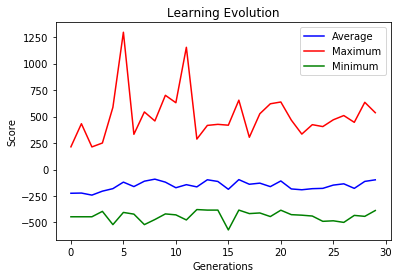

In [5]:
plotLearningEvolution(generationAverage, generationMax, generationMin)

Depois, executamos 30 gerações para o layout mediumClassic:

In [6]:
generation = createGeneration()
generationAverage, generationMax, generationMin, mediumClassicStrategy = runGeneticLearning("mediumClassic", generation)

layout:  mediumClassic



======== STARTING GENERATION 0 ========



Pacman died! Score: -216
Average Score: -216.0
Scores:        -216.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -353
Average Score: -353.0
Scores:        -353.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -311
Average Score: -311.0
Scores:        -311.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -265
Average Score: -265.0
Scores:        -265.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -437
Average Score: -437.0
Scores:        -437.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -366
Average Score: -366.0
Scores:        -366.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -444
Average Score: -444.0
Scores:        -444.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 101
Average Score: 101.0
Scores:        101.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! S

Pacman died! Score: -177
Average Score: -177.0
Scores:        -177.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -311
Average Score: -311.0
Scores:        -311.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -357
Average Score: -357.0
Scores:        -357.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 36
Average Score: 36.0
Scores:        36.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -305
Average Score: -305.0
Scores:        -305.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 325
Average Score: 325.0
Scores:        325.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -471
Average Score: -471.0
Scores:        -471.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -408
Average Score: -408.0
Scores:        -408.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -31
Average Score: -31.0
Scores:        -31.0
Win Rate:      0/1 (0.0

Pacman died! Score: -389
Average Score: -389.0
Scores:        -389.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -166
Average Score: -166.0
Scores:        -166.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 3
Average Score: 3.0
Scores:        3.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -79
Average Score: -79.0
Scores:        -79.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -113
Average Score: -113.0
Scores:        -113.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -365
Average Score: -365.0
Scores:        -365.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -255
Average Score: -255.0
Scores:        -255.0
Win Rate:      0/1 (0.00)
Record:        Loss



======== STARTING GENERATION 3 ========



Pacman died! Score: 249
Average Score: 249.0
Scores:        249.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -392
Average Score: -392.0
Sc

Pacman died! Score: -466
Average Score: -466.0
Scores:        -466.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -42
Average Score: -42.0
Scores:        -42.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -265
Average Score: -265.0
Scores:        -265.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -490
Average Score: -490.0
Scores:        -490.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 11
Average Score: 11.0
Scores:        11.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 69
Average Score: 69.0
Scores:        69.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -363
Average Score: -363.0
Scores:        -363.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 166
Average Score: 166.0
Scores:        166.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -60
Average Score: -60.0
Scores:        -60.0
Win Rate:      0/1 (0.00)
Record

Pacman died! Score: -369
Average Score: -369.0
Scores:        -369.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 12
Average Score: 12.0
Scores:        12.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 72
Average Score: 72.0
Scores:        72.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -365
Average Score: -365.0
Scores:        -365.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -419
Average Score: -419.0
Scores:        -419.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -425
Average Score: -425.0
Scores:        -425.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -302
Average Score: -302.0
Scores:        -302.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -225
Average Score: -225.0
Scores:        -225.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -106
Average Score: -106.0
Scores:        -106.0
Win Rate:      0/1 (0.0

Pacman died! Score: -240
Average Score: -240.0
Scores:        -240.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -401
Average Score: -401.0
Scores:        -401.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -347
Average Score: -347.0
Scores:        -347.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -401
Average Score: -401.0
Scores:        -401.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -26
Average Score: -26.0
Scores:        -26.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -221
Average Score: -221.0
Scores:        -221.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -20
Average Score: -20.0
Scores:        -20.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -394
Average Score: -394.0
Scores:        -394.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -87
Average Score: -87.0
Scores:        -87.0
Win Rate:      0/1 (

Pacman died! Score: -354
Average Score: -354.0
Scores:        -354.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -37
Average Score: -37.0
Scores:        -37.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -224
Average Score: -224.0
Scores:        -224.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -268
Average Score: -268.0
Scores:        -268.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -112
Average Score: -112.0
Scores:        -112.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -84
Average Score: -84.0
Scores:        -84.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -94
Average Score: -94.0
Scores:        -94.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -679
Average Score: -679.0
Scores:        -679.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -81
Average Score: -81.0
Scores:        -81.0
Win Rate:      0/1 (0.0

Pacman died! Score: -299
Average Score: -299.0
Scores:        -299.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -320
Average Score: -320.0
Scores:        -320.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 17
Average Score: 17.0
Scores:        17.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -275
Average Score: -275.0
Scores:        -275.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 135
Average Score: 135.0
Scores:        135.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -302
Average Score: -302.0
Scores:        -302.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -285
Average Score: -285.0
Scores:        -285.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -357
Average Score: -357.0
Scores:        -357.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -14
Average Score: -14.0
Scores:        -14.0
Win Rate:      0/1 (0.0

Pacman died! Score: -50
Average Score: -50.0
Scores:        -50.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -347
Average Score: -347.0
Scores:        -347.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -314
Average Score: -314.0
Scores:        -314.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -330
Average Score: -330.0
Scores:        -330.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 40
Average Score: 40.0
Scores:        40.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 300
Average Score: 300.0
Scores:        300.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -428
Average Score: -428.0
Scores:        -428.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -351
Average Score: -351.0
Scores:        -351.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -92
Average Score: -92.0
Scores:        -92.0
Win Rate:      0/1 (0.00)


Pacman died! Score: -359
Average Score: -359.0
Scores:        -359.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -155
Average Score: -155.0
Scores:        -155.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -60
Average Score: -60.0
Scores:        -60.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -257
Average Score: -257.0
Scores:        -257.0
Win Rate:      0/1 (0.00)
Record:        Loss



======== STARTING GENERATION 13 ========



Pacman died! Score: -374
Average Score: -374.0
Scores:        -374.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 4
Average Score: 4.0
Scores:        4.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -106
Average Score: -106.0
Scores:        -106.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -282
Average Score: -282.0
Scores:        -282.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -65
Average Score: -65.0


Pacman died! Score: -110
Average Score: -110.0
Scores:        -110.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 393
Average Score: 393.0
Scores:        393.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 132
Average Score: 132.0
Scores:        132.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -320
Average Score: -320.0
Scores:        -320.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 210
Average Score: 210.0
Scores:        210.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -250
Average Score: -250.0
Scores:        -250.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -374
Average Score: -374.0
Scores:        -374.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -289
Average Score: -289.0
Scores:        -289.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -300
Average Score: -300.0
Scores:        -300.0
Win Rate:      0/1 (

Pacman died! Score: -108
Average Score: -108.0
Scores:        -108.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -302
Average Score: -302.0
Scores:        -302.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -361
Average Score: -361.0
Scores:        -361.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 143
Average Score: 143.0
Scores:        143.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -104
Average Score: -104.0
Scores:        -104.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -273
Average Score: -273.0
Scores:        -273.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -410
Average Score: -410.0
Scores:        -410.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -347
Average Score: -347.0
Scores:        -347.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -428
Average Score: -428.0
Scores:        -428.0
Win Rate:     

Pacman died! Score: -363
Average Score: -363.0
Scores:        -363.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 143
Average Score: 143.0
Scores:        143.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -42
Average Score: -42.0
Scores:        -42.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 389
Average Score: 389.0
Scores:        389.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -268
Average Score: -268.0
Scores:        -268.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -137
Average Score: -137.0
Scores:        -137.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -20
Average Score: -20.0
Scores:        -20.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -265
Average Score: -265.0
Scores:        -265.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -210
Average Score: -210.0
Scores:        -210.0
Win Rate:      0/1 (0.0

Pacman died! Score: -349
Average Score: -349.0
Scores:        -349.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -425
Average Score: -425.0
Scores:        -425.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -321
Average Score: -321.0
Scores:        -321.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -282
Average Score: -282.0
Scores:        -282.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -133
Average Score: -133.0
Scores:        -133.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -363
Average Score: -363.0
Scores:        -363.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -352
Average Score: -352.0
Scores:        -352.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 357
Average Score: 357.0
Scores:        357.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -67
Average Score: -67.0
Scores:        -67.0
Win Rate:      0/

Pacman died! Score: -54
Average Score: -54.0
Scores:        -54.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 144
Average Score: 144.0
Scores:        144.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 192
Average Score: 192.0
Scores:        192.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -133
Average Score: -133.0
Scores:        -133.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -203
Average Score: -203.0
Scores:        -203.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -267
Average Score: -267.0
Scores:        -267.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -64
Average Score: -64.0
Scores:        -64.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -365
Average Score: -365.0
Scores:        -365.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -83
Average Score: -83.0
Scores:        -83.0
Win Rate:      0/1 (0.00)


Pacman died! Score: -3
Average Score: -3.0
Scores:        -3.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -547
Average Score: -547.0
Scores:        -547.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -330
Average Score: -330.0
Scores:        -330.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 7
Average Score: 7.0
Scores:        7.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 114
Average Score: 114.0
Scores:        114.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -367
Average Score: -367.0
Scores:        -367.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 169
Average Score: 169.0
Scores:        169.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 204
Average Score: 204.0
Scores:        204.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -152
Average Score: -152.0
Scores:        -152.0
Win Rate:      0/1 (0.00)
Record:  

Pacman died! Score: 249
Average Score: 249.0
Scores:        249.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -587
Average Score: -587.0
Scores:        -587.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -67
Average Score: -67.0
Scores:        -67.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -118
Average Score: -118.0
Scores:        -118.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 38
Average Score: 38.0
Scores:        38.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -547
Average Score: -547.0
Scores:        -547.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -317
Average Score: -317.0
Scores:        -317.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -121
Average Score: -121.0
Scores:        -121.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -265
Average Score: -265.0
Scores:        -265.0
Win Rate:      0/1 (0.0

Pacman died! Score: -30
Average Score: -30.0
Scores:        -30.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -278
Average Score: -278.0
Scores:        -278.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -75
Average Score: -75.0
Scores:        -75.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -401
Average Score: -401.0
Scores:        -401.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -222
Average Score: -222.0
Scores:        -222.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -65
Average Score: -65.0
Scores:        -65.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -117
Average Score: -117.0
Scores:        -117.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -96
Average Score: -96.0
Scores:        -96.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -433
Average Score: -433.0
Scores:        -433.0
Win Rate:      0/1 (0.0

Pacman died! Score: 339
Average Score: 339.0
Scores:        339.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -361
Average Score: -361.0
Scores:        -361.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -279
Average Score: -279.0
Scores:        -279.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 79
Average Score: 79.0
Scores:        79.0
Win Rate:      0/1 (0.00)
Record:        Loss



======== STARTING GENERATION 26 ========



Pacman died! Score: -73
Average Score: -73.0
Scores:        -73.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 466
Average Score: 466.0
Scores:        466.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -257
Average Score: -257.0
Scores:        -257.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -3
Average Score: -3.0
Scores:        -3.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -329
Average Score: -329.0
Scores:

Pacman died! Score: 399
Average Score: 399.0
Scores:        399.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 268
Average Score: 268.0
Scores:        268.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -57
Average Score: -57.0
Scores:        -57.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -403
Average Score: -403.0
Scores:        -403.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 370
Average Score: 370.0
Scores:        370.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 86
Average Score: 86.0
Scores:        86.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 490
Average Score: 490.0
Scores:        490.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -284
Average Score: -284.0
Scores:        -284.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -64
Average Score: -64.0
Scores:        -64.0
Win Rate:      0/1 (0.00)
Record:  

Pacman died! Score: -42
Average Score: -42.0
Scores:        -42.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 45
Average Score: 45.0
Scores:        45.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -125
Average Score: -125.0
Scores:        -125.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 122
Average Score: 122.0
Scores:        122.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 119
Average Score: 119.0
Scores:        119.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -28
Average Score: -28.0
Scores:        -28.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -260
Average Score: -260.0
Scores:        -260.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -340
Average Score: -340.0
Scores:        -340.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -174
Average Score: -174.0
Scores:        -174.0
Win Rate:      0/1 (0.00)
Rec

Pacman died! Score: 159
Pacman died! Score: -347
Pacman died! Score: -171
Pacman died! Score: -145
Pacman died! Score: 107
Pacman died! Score: 467
Average Score: 16.6
Scores:        76.0, -163.0, -30.0, 213.0, 159.0, -347.0, -171.0, -145.0, 107.0, 467.0
Win Rate:      0/10 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss
Pacman died! Score: 406
Pacman died! Score: 264
Pacman died! Score: 318
Pacman died! Score: 19
Pacman died! Score: 575
Pacman died! Score: 510
Pacman died! Score: -392
Pacman died! Score: 74
Pacman died! Score: 132
Pacman died! Score: -80
Average Score: 182.6
Scores:        406.0, 264.0, 318.0, 19.0, 575.0, 510.0, -392.0, 74.0, 132.0, -80.0
Win Rate:      0/10 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss
Pacman died! Score: -181
Pacman died! Score: 46
Pacman died! Score: -228
Pacman died! Score: 49
Pacman died! Score: -190
Pacman died! Score: -69
Pacman died! Score: -221
Pacman died! Score: 121
Pacman 

Pacman died! Score: -211
Pacman died! Score: -235
Average Score: 42.9
Scores:        -16.0, -67.0, -222.0, 517.0, -37.0, 36.0, 433.0, 231.0, -211.0, -235.0
Win Rate:      0/10 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss
Pacman died! Score: -82
Pacman died! Score: 237
Pacman died! Score: 456
Pacman died! Score: -266
Pacman died! Score: -150
Pacman died! Score: -160
Pacman died! Score: 279
Pacman died! Score: -338
Pacman died! Score: -430
Pacman died! Score: -178
Average Score: -63.2
Scores:        -82.0, 237.0, 456.0, -266.0, -150.0, -160.0, 279.0, -338.0, -430.0, -178.0
Win Rate:      0/10 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss
Pacman died! Score: 436
Pacman died! Score: -300
Pacman died! Score: -401
Pacman died! Score: 146
Pacman died! Score: 228
Pacman died! Score: -285
Pacman died! Score: -103
Pacman died! Score: -9
Pacman died! Score: 297
Pacman died! Score: -118
Average Score: -10.9
Scores:        436.0

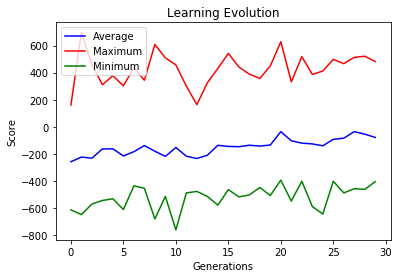

In [7]:
plotLearningEvolution(generationAverage, generationMax, generationMin)

Por último, executamos 30 gerações para o layout originalClassic:

In [8]:
generation = createGeneration()
generationAverage, generationMax, generationMin, originalClassicStrategy = runGeneticLearning("originalClassic", generation)

layout:  originalClassic



======== STARTING GENERATION 0 ========



Pacman died! Score: -205
Average Score: -205.0
Scores:        -205.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 617
Average Score: 617.0
Scores:        617.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 564
Average Score: 564.0
Scores:        564.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 239
Average Score: 239.0
Scores:        239.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -151
Average Score: -151.0
Scores:        -151.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -235
Average Score: -235.0
Scores:        -235.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -333
Average Score: -333.0
Scores:        -333.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 5
Average Score: 5.0
Scores:        5.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -257
Av

Pacman died! Score: 96
Average Score: 96.0
Scores:        96.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 439
Average Score: 439.0
Scores:        439.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -407
Average Score: -407.0
Scores:        -407.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 233
Average Score: 233.0
Scores:        233.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 124
Average Score: 124.0
Scores:        124.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 1159
Average Score: 1159.0
Scores:        1159.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 237
Average Score: 237.0
Scores:        237.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 90
Average Score: 90.0
Scores:        90.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 218
Average Score: 218.0
Scores:        218.0
Win Rate:      0/1 (0.00)
Record:     

Pacman died! Score: 33
Average Score: 33.0
Scores:        33.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 330
Average Score: 330.0
Scores:        330.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -228
Average Score: -228.0
Scores:        -228.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -85
Average Score: -85.0
Scores:        -85.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 166
Average Score: 166.0
Scores:        166.0
Win Rate:      0/1 (0.00)
Record:        Loss



======== STARTING GENERATION 3 ========



Pacman died! Score: -13
Average Score: -13.0
Scores:        -13.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -338
Average Score: -338.0
Scores:        -338.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 309
Average Score: 309.0
Scores:        309.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -97
Average Score: -97.0
Scores:   

Pacman died! Score: 103
Average Score: 103.0
Scores:        103.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -340
Average Score: -340.0
Scores:        -340.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 291
Average Score: 291.0
Scores:        291.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -222
Average Score: -222.0
Scores:        -222.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -329
Average Score: -329.0
Scores:        -329.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -128
Average Score: -128.0
Scores:        -128.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 143
Average Score: 143.0
Scores:        143.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 463
Average Score: 463.0
Scores:        463.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -192
Average Score: -192.0
Scores:        -192.0
Win Rate:      0/1 (0.0

Pacman died! Score: 78
Average Score: 78.0
Scores:        78.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 304
Average Score: 304.0
Scores:        304.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -216
Average Score: -216.0
Scores:        -216.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 1318
Average Score: 1318.0
Scores:        1318.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -116
Average Score: -116.0
Scores:        -116.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -165
Average Score: -165.0
Scores:        -165.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -356
Average Score: -356.0
Scores:        -356.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -335
Average Score: -335.0
Scores:        -335.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 139
Average Score: 139.0
Scores:        139.0
Win Rate:      0/1 (0.0

Pacman died! Score: -156
Average Score: -156.0
Scores:        -156.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 186
Average Score: 186.0
Scores:        186.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 601
Average Score: 601.0
Scores:        601.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -84
Average Score: -84.0
Scores:        -84.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 46
Average Score: 46.0
Scores:        46.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 473
Average Score: 473.0
Scores:        473.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 165
Average Score: 165.0
Scores:        165.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 292
Average Score: 292.0
Scores:        292.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -34
Average Score: -34.0
Scores:        -34.0
Win Rate:      0/1 (0.00)
Record:     

Pacman died! Score: -241
Average Score: -241.0
Scores:        -241.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -87
Average Score: -87.0
Scores:        -87.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -248
Average Score: -248.0
Scores:        -248.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -122
Average Score: -122.0
Scores:        -122.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 401
Average Score: 401.0
Scores:        401.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 1001
Average Score: 1001.0
Scores:        1001.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -54
Average Score: -54.0
Scores:        -54.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 271
Average Score: 271.0
Scores:        271.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 627
Average Score: 627.0
Scores:        627.0
Win Rate:      0/1 (0.00)


Pacman died! Score: 170
Average Score: 170.0
Scores:        170.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 375
Average Score: 375.0
Scores:        375.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 647
Average Score: 647.0
Scores:        647.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 456
Average Score: 456.0
Scores:        456.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 231
Average Score: 231.0
Scores:        231.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 391
Average Score: 391.0
Scores:        391.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 607
Average Score: 607.0
Scores:        607.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 451
Average Score: 451.0
Scores:        451.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 155
Average Score: 155.0
Scores:        155.0
Win Rate:      0/1 (0.00)
Record:     

Pacman died! Score: -257
Average Score: -257.0
Scores:        -257.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 167
Average Score: 167.0
Scores:        167.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -221
Average Score: -221.0
Scores:        -221.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -143
Average Score: -143.0
Scores:        -143.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -107
Average Score: -107.0
Scores:        -107.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -205
Average Score: -205.0
Scores:        -205.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 356
Average Score: 356.0
Scores:        356.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -176
Average Score: -176.0
Scores:        -176.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -112
Average Score: -112.0
Scores:        -112.0
Win Rate:      0/

Pacman died! Score: 1
Average Score: 1.0
Scores:        1.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 383
Average Score: 383.0
Scores:        383.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -230
Average Score: -230.0
Scores:        -230.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 72
Average Score: 72.0
Scores:        72.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 110
Average Score: 110.0
Scores:        110.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -186
Average Score: -186.0
Scores:        -186.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 97
Average Score: 97.0
Scores:        97.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 368
Average Score: 368.0
Scores:        368.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 292
Average Score: 292.0
Scores:        292.0
Win Rate:      0/1 (0.00)
Record:        Los

Pacman died! Score: -187
Average Score: -187.0
Scores:        -187.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 931
Average Score: 931.0
Scores:        931.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 717
Average Score: 717.0
Scores:        717.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 40
Average Score: 40.0
Scores:        40.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 1465
Average Score: 1465.0
Scores:        1465.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 154
Average Score: 154.0
Scores:        154.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 270
Average Score: 270.0
Scores:        270.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 102
Average Score: 102.0
Scores:        102.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 49
Average Score: 49.0
Scores:        49.0
Win Rate:      0/1 (0.00)
Record:     

Pacman died! Score: 241
Average Score: 241.0
Scores:        241.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -187
Average Score: -187.0
Scores:        -187.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 688
Average Score: 688.0
Scores:        688.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 856
Average Score: 856.0
Scores:        856.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 370
Average Score: 370.0
Scores:        370.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 217
Average Score: 217.0
Scores:        217.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 175
Average Score: 175.0
Scores:        175.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 127
Average Score: 127.0
Scores:        127.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 702
Average Score: 702.0
Scores:        702.0
Win Rate:      0/1 (0.00)
Record:  

Pacman died! Score: 191
Average Score: 191.0
Scores:        191.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 515
Average Score: 515.0
Scores:        515.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -293
Average Score: -293.0
Scores:        -293.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 304
Average Score: 304.0
Scores:        304.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 369
Average Score: 369.0
Scores:        369.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -338
Average Score: -338.0
Scores:        -338.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 475
Average Score: 475.0
Scores:        475.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 313
Average Score: 313.0
Scores:        313.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 490
Average Score: 490.0
Scores:        490.0
Win Rate:      0/1 (0.00)
Record

Pacman died! Score: 311
Average Score: 311.0
Scores:        311.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -335
Average Score: -335.0
Scores:        -335.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -154
Average Score: -154.0
Scores:        -154.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 317
Average Score: 317.0
Scores:        317.0
Win Rate:      0/1 (0.00)
Record:        Loss



======== STARTING GENERATION 19 ========



Pacman died! Score: 259
Average Score: 259.0
Scores:        259.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 588
Average Score: 588.0
Scores:        588.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 195
Average Score: 195.0
Scores:        195.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 548
Average Score: 548.0
Scores:        548.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -329
Average Score: -329.0
Scor

Pacman died! Score: -203
Average Score: -203.0
Scores:        -203.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -178
Average Score: -178.0
Scores:        -178.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 388
Average Score: 388.0
Scores:        388.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 109
Average Score: 109.0
Scores:        109.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 266
Average Score: 266.0
Scores:        266.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 245
Average Score: 245.0
Scores:        245.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 100
Average Score: 100.0
Scores:        100.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -338
Average Score: -338.0
Scores:        -338.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 48
Average Score: 48.0
Scores:        48.0
Win Rate:      0/1 (0.00)
Record

Pacman died! Score: -205
Average Score: -205.0
Scores:        -205.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -243
Average Score: -243.0
Scores:        -243.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 12
Average Score: 12.0
Scores:        12.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 319
Average Score: 319.0
Scores:        319.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 525
Average Score: 525.0
Scores:        525.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 790
Average Score: 790.0
Scores:        790.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 361
Average Score: 361.0
Scores:        361.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 227
Average Score: 227.0
Scores:        227.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 48
Average Score: 48.0
Scores:        48.0
Win Rate:      0/1 (0.00)
Record:     

Pacman died! Score: 861
Average Score: 861.0
Scores:        861.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -178
Average Score: -178.0
Scores:        -178.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 329
Average Score: 329.0
Scores:        329.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 528
Average Score: 528.0
Scores:        528.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -7
Average Score: -7.0
Scores:        -7.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 85
Average Score: 85.0
Scores:        85.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 760
Average Score: 760.0
Scores:        760.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 169
Average Score: 169.0
Scores:        169.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -71
Average Score: -71.0
Scores:        -71.0
Win Rate:      0/1 (0.00)
Record:        

Pacman died! Score: 333
Average Score: 333.0
Scores:        333.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 391
Average Score: 391.0
Scores:        391.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 143
Average Score: 143.0
Scores:        143.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -150
Average Score: -150.0
Scores:        -150.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 262
Average Score: 262.0
Scores:        262.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 147
Average Score: 147.0
Scores:        147.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -221
Average Score: -221.0
Scores:        -221.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -333
Average Score: -333.0
Scores:        -333.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -44
Average Score: -44.0
Scores:        -44.0
Win Rate:      0/1 (0.00)
Rec

Pacman died! Score: 460
Average Score: 460.0
Scores:        460.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 74
Average Score: 74.0
Scores:        74.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -147
Average Score: -147.0
Scores:        -147.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 1473
Average Score: 1473.0
Scores:        1473.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 626
Average Score: 626.0
Scores:        626.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 569
Average Score: 569.0
Scores:        569.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 66
Average Score: 66.0
Scores:        66.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -51
Average Score: -51.0
Scores:        -51.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 398
Average Score: 398.0
Scores:        398.0
Win Rate:      0/1 (0.00)
Record:     

Pacman died! Score: 646
Average Score: 646.0
Scores:        646.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -215
Average Score: -215.0
Scores:        -215.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -59
Average Score: -59.0
Scores:        -59.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -239
Average Score: -239.0
Scores:        -239.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 430
Average Score: 430.0
Scores:        430.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -257
Average Score: -257.0
Scores:        -257.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -70
Average Score: -70.0
Scores:        -70.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -241
Average Score: -241.0
Scores:        -241.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -133
Average Score: -133.0
Scores:        -133.0
Win Rate:      0/1 (0.0

Pacman died! Score: 384
Average Score: 384.0
Scores:        384.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 318
Average Score: 318.0
Scores:        318.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 134
Average Score: 134.0
Scores:        134.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 739
Average Score: 739.0
Scores:        739.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 665
Average Score: 665.0
Scores:        665.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -19
Average Score: -19.0
Scores:        -19.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: -442
Average Score: -442.0
Scores:        -442.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 475
Average Score: 475.0
Scores:        475.0
Win Rate:      0/1 (0.00)
Record:        Loss
Pacman died! Score: 661
Average Score: 661.0
Scores:        661.0
Win Rate:      0/1 (0.00)
Record:  

Pacman died! Score: 484
Pacman died! Score: 904
Pacman died! Score: 156
Pacman died! Score: 670
Pacman died! Score: 140
Pacman died! Score: 591
Pacman died! Score: 1018
Pacman died! Score: 75
Pacman died! Score: 49
Pacman died! Score: 705
Average Score: 479.2
Scores:        484.0, 904.0, 156.0, 670.0, 140.0, 591.0, 1018.0, 75.0, 49.0, 705.0
Win Rate:      0/10 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss
Pacman died! Score: -252
Pacman died! Score: 125
Pacman died! Score: 157
Pacman died! Score: 940
Pacman died! Score: 20
Pacman died! Score: -223
Pacman died! Score: -115
Pacman died! Score: -87
Pacman died! Score: -129
Pacman died! Score: 576
Average Score: 101.2
Scores:        -252.0, 125.0, 157.0, 940.0, 20.0, -223.0, -115.0, -87.0, -129.0, 576.0
Win Rate:      0/10 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss
Pacman died! Score: 665
Pacman died! Score: 490
Pacman died! Score: -239
Pacman died! Score: 710
Pacman 

Pacman died! Score: -241
Pacman died! Score: -160
Pacman died! Score: 185
Pacman died! Score: -106
Average Score: 252.7
Scores:        329.0, 386.0, 512.0, 669.0, 488.0, 465.0, -241.0, -160.0, 185.0, -106.0
Win Rate:      0/10 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss
Pacman died! Score: 102
Pacman died! Score: -328
Pacman died! Score: 520
Pacman died! Score: 183
Pacman died! Score: 400
Pacman died! Score: 832
Pacman died! Score: 511
Pacman died! Score: 412
Pacman died! Score: -329
Pacman died! Score: -293
Average Score: 201.0
Scores:        102.0, -328.0, 520.0, 183.0, 400.0, 832.0, 511.0, 412.0, -329.0, -293.0
Win Rate:      0/10 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss
Pacman died! Score: 285
Pacman died! Score: -158
Pacman died! Score: 71
Pacman died! Score: 105
Pacman died! Score: 29
Pacman died! Score: 593
Pacman died! Score: 40
Pacman died! Score: -56
Pacman died! Score: 35
Pacman died! Score: 157
Ave

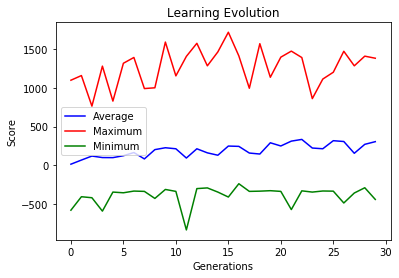

In [9]:
plotLearningEvolution(generationAverage, generationMax, generationMin)

### Análise dos Resultados

Observando os gráficos acima, perebemos que a estratégias melhoram no decorrer do treinamento. Os gráficos parecem sugerir que, rodando mais gerações, obteríamos resultados ainda melhores. Contudo, o tempo de execução se torna inviável com um número de gerações muito grande.

Inicialmente, nosso modelo possuía apenas uma linha de árvores para cada estratégia e permitia que o Pacman pudesse inverter sua direção a qualquer momento. Dentre diversas alterações que fizemos no decorrer do desenvolvimento de nosso modelo, estas duas apresentaram a mudança mais drástica nos resultados.

O modelo baseado em votação é mais capaz de gerar estratégias mais complexas além de garantir uma maior semelhança de um estratégia gerada por crossover de seus ascendentes. Já o impedimento de inversão de direção na maioria dos casos, impediu que o Pacman ficasse em loop, o que ocorria muito frequentemente nos modelos treinados inicialmente, o que não só impedia que mais comidas fossem coletadas como aumentava o tempo para que os fantasmas atingissem o jogador, diminuindo ainda mais a pontuação média.

Rodamos, então, 10 jogos para cada layout com as estratégias selecionadas:

In [13]:
args = pacman.readCommand(["-l", "smallClassic", "-p", "GeneticAgent", "-n", "10", "-q"])
globalValues.strategy = smallClassicStrategy
games = pacman.runGames(**args)

layout:  smallClassic
Pacman died! Score: 290
Pacman died! Score: 324
Pacman died! Score: -374
Pacman died! Score: -347
Pacman died! Score: 39
Pacman died! Score: 240
Pacman died! Score: -24
Pacman died! Score: -329
Pacman died! Score: 17
Pacman died! Score: 259
Average Score: 9.5
Scores:        290.0, 324.0, -374.0, -347.0, 39.0, 240.0, -24.0, -329.0, 17.0, 259.0
Win Rate:      0/10 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss


In [11]:
args = pacman.readCommand(["-l", "mediumClassic", "-p", "GeneticAgent", "-n", "10", "-q"])
globalValues.strategy = mediumClassicStrategy
games = pacman.runGames(**args)

layout:  mediumClassic
Pacman died! Score: 46
Pacman died! Score: 155
Pacman died! Score: 340
Pacman died! Score: 178
Pacman died! Score: -264
Pacman died! Score: 308
Pacman died! Score: 5
Pacman died! Score: 98
Pacman died! Score: 216
Pacman died! Score: 335
Average Score: 141.7
Scores:        46.0, 155.0, 340.0, 178.0, -264.0, 308.0, 5.0, 98.0, 216.0, 335.0
Win Rate:      0/10 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss


In [12]:
args = pacman.readCommand(["-l", "originalClassic", "-p", "GeneticAgent", "-n", "10", "-q"])
globalValues.strategy = originalClassicStrategy
games = pacman.runGames(**args)

layout:  originalClassic
Pacman died! Score: 862
Pacman died! Score: 877
Pacman died! Score: 823
Pacman died! Score: 1029
Pacman died! Score: -330
Pacman died! Score: 527
Pacman died! Score: 1485
Pacman died! Score: 237
Pacman died! Score: 730
Pacman died! Score: 458
Average Score: 669.8
Scores:        862.0, 877.0, 823.0, 1029.0, -330.0, 527.0, 1485.0, 237.0, 730.0, 458.0
Win Rate:      0/10 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss
